# Example script to estimate the uncertainty via Conformal Prediction

In [1]:
import sys
import os
import csv
import numpy as np
import pickle
import copy
import ase.io
import numpy as np
import torch
from ase import Atoms
from ase.calculators.emt import EMT

from amptorch.trainer import AtomsTrainer
from numpy.random import default_rng, uniform

from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler

from scipy.stats import gaussian_kde

import matplotlib
from matplotlib import pyplot as plt

In [2]:
# generating the training images
distances = np.linspace(2, 5, 1000)
train_list = []
for dist in distances:
    image = Atoms(
        "CuCO",
        [
            (-dist * np.sin(0.65), dist * np.cos(0.65), 0),
            (0, 0, 0),
            (dist * np.sin(0.65), dist * np.cos(0.65), 0),
        ],
    )
    image.set_cell([10, 10, 10])
    image.wrap(pbc=True)
    image.set_calculator(EMT())
    train_list.append(image)

    
# generating the test images
default_rng(12345)
distances = uniform(low=2, high=5, size=200)
test_list = []
for dist in distances:
    image = Atoms(
        "CuCO",
        [
            (-dist * np.sin(0.65), dist * np.cos(0.65), 0),
            (0, 0, 0),
            (dist * np.sin(0.65), dist * np.cos(0.65), 0),
        ],
    )
    image.set_cell([10, 10, 10])
    image.wrap(pbc=True)
    image.set_calculator(EMT())
    test_list.append(image)
    

# set up the trainer
sigmas = [0.02, 0.2, 0.4, 0.69, 1.1, 1.66, 2.66, 4.4]
MCSHs = {
    "MCSHs": {
        "0": {"groups": [1], "sigmas": sigmas},
        "1": {"groups": [1], "sigmas": sigmas},
        "2": {"groups": [1, 2], "sigmas": sigmas},
        "3": {"groups": [1, 2, 3], "sigmas": sigmas},
        # "4": {"groups": [1, 2, 3, 4], "sigmas": sigmas},
        # "5": {"groups": [1, 2, 3, 4, 5], "sigmas": sigmas},
        # "6": {"groups": [1, 2, 3, 4, 5, 6, 7], "sigmas": sigmas},
    },
    "atom_gaussians": {
        "C": "./valence_gaussians/C_pseudodensity_4.g",
        "O": "./valence_gaussians/O_pseudodensity_4.g",
        "Cu": "./valence_gaussians/Cu_pseudodensity_4.g",
    },
    "cutoff": 8,
}


elements = ["Cu", "C", "O"]
config = {
    "model": {
        "name": "singlenn",
        "get_forces": False,
        "num_layers": 3,
        "num_nodes": 20,
    },
    "optim": {
        "device": "cpu",
        "force_coefficient": 0.0,
        "lr": 1e-2,
        "batch_size": 10,
        "epochs": 100,
    },
    "dataset": {
        "raw_data": train_list,
        "val_split": 0,
        "elements": elements,
        "fp_scheme": "gmp",
        "fp_params": MCSHs,
        "save_fps": True,
    },
    "cmd": {
        "debug": False,
        "run_dir": "./",
        "seed": 1,
        "identifier": "test",
        "verbose": True,
        "logger": False,
    },
}

# train
trainer = AtomsTrainer(config)
trainer.train()

Results saved to ./checkpoints/2022-07-01-15-31-32-test



Loading dataset: 1000 images
Use Xavier initialization
Loading model: 2001 parameters
Loading skorch trainer
  epoch    train_energy_mae    train_loss    cp     dur
-------  ------------------  ------------  ----  ------
      1              0.1450        0.0492     +  0.1826
      2              0.0197        0.0005     +  0.1797


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


      3              0.0095        0.0001     +  0.1806
      4              0.0100        0.0001        0.1811
      5              0.0153        0.0003        0.1790
      6              0.0109        0.0002        0.1806
      7              0.0245        0.0008        0.1789
      8              0.0374        0.0019        0.1784
      9              0.0224        0.0009        0.1792
     10              0.0065        0.0001     +  0.1796
     11              0.0168        0.0004        0.1800
     12              0.0096        0.0001        0.1802
     13              0.0062        0.0001     +  0.1812
     14              0.0223        0.0007        0.1809
     15              0.0430        0.0027        0.1805
     16              0.0288        0.0012        0.1836
     17              0.0110        0.0001        0.1832
     18              0.0176        0.0004        0.1802
     19              0.0143        0.0004        0.1792
     20              0.0061        0.0001     + 

In [3]:
# utils for CP

def calc_dist(train_X, calib_X, nearest_neighbors=10, metric="minkowski"):
    """
    Returns the distances of calibration data to training data
    """
    std_scaler = StandardScaler().fit(train_X)
    train_X_std_scaled = std_scaler.transform(train_X)
    calib_X_std_scaled = std_scaler.transform(calib_X)
    
    kdtree = KDTree(train_X_std_scaled, metric=metric)
    dist, ind = kdtree.query(calib_X_std_scaled, k=nearest_neighbors)
    
    return dist.mean(axis=1)

def predict_data(pred_energies, test_images):
    """
    Returns the residuals between ground truth energy and the predicted energy by trainer object
    """
    true_energies = np.array([image.get_potential_energy() for image in test_images])

    list_of_error = []

    for i, image in enumerate(test_images):
        num_atoms = len(image.get_atomic_numbers())
        total_energy_pred = pred_energies[i]
        total_energy_true = true_energies[i]

        error = pred_energies[i] - true_energies[i]
        list_of_error.append(error)

    return list_of_error

class ConformalPrediction():
    """
    Performs quantile regression on score functions to obtain the estimated qhat 
        on calibration data and apply to test data during prediction. 
    """
    def __init__(self, residuals_calib, heurestic_uncertainty_calib, alpha) -> None:
        # score function
        scores = abs(residuals_calib / heurestic_uncertainty_calib)
        scores = np.array(scores)

        n=len(residuals_calib)
        qhat = torch.quantile(torch.from_numpy(scores), np.ceil((n + 1) * (1 - alpha)) / n)
        qhat_value = np.float64(qhat.numpy())
        self.qhat = qhat_value
        pass

    def predict(self, heurestic_uncertainty_test):
        return heurestic_uncertainty_test * self.qhat, self.qhat


def split_test_calib(full_test_X, full_test_y, per_calib, seed=0):
    """
    Uniformaly sample the test data at random to split a list for test data and a list for calibration. 
    """
    # sub-select calib and test
    np.random.seed(seed)

    # num_total=5000
    num_total = len(full_test_X)

    num_calib = round(per_calib * num_total)

    rand_idx = np.random.choice(num_total, size=num_total, replace=False)
    calib_idx = rand_idx[:num_calib]
    test_idx = rand_idx[num_calib::]

    calib_X = [full_test_X[_] for _ in calib_idx]
    test_X = [full_test_X[_] for _ in test_idx]

    calib_y = [full_test_y[_] for _ in calib_idx]
    test_y = [full_test_y[_] for _ in test_idx]

    return test_X, test_y, calib_X, calib_y


def prepare_latentNerror_from_trainer(trainer, images, get_latent=-2):
    """
    Return the latent representations and respective residuals for data list. 
    """
    predictions = trainer.predict(images, get_latent=get_latent)
    feature = np.array(predictions["latent"])

    # errors for train, test, calib
    y_bar = np.array(predictions["energy"])
    list_error = predict_data(y_bar, images)
    list_error = np.array(list_error)


    return feature, list_error

def calc_uncertainty_metrics(list_epa, uncertainty):
    """
    Quantifies how the observed confidence level as sample coverage and the average widths of
        prediction sets. 
    """
    overconfident_idx = np.argwhere(abs(list_epa) > uncertainty)

    prob_overconfidence = len(overconfident_idx) / len(uncertainty)
    avg_uncertainty = np.mean(uncertainty)
    
    return prob_overconfidence, avg_uncertainty

In [4]:
# hyperparameters for CP

get_latent= -2
per_calib=0.1
seed=1
num_nearest_neighbors=10
metric = "minkowski"

In [5]:
# plot setting
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
colors=["#f14432", "#fc8a6a"]

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# Set figure defaults
width = 6.5 / 3
fontsize = 10
rc = {'figure.figsize': (width, width),
#       'font.family': "serif",
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': 'small',
      'ytick.labelsize': 'small',
      'legend.fontsize': fontsize}

matplotlib.rcParams.update(rc)

In [6]:
# compute the latent representations and residuals for train and test data
train_X, train_y = prepare_latentNerror_from_trainer(trainer, train_list, get_latent=get_latent)
full_test_X, full_test_y = prepare_latentNerror_from_trainer(trainer, test_list, get_latent=get_latent)

latent layer -2
latent layer -2


In [7]:
# predict test and calib
test_X, test_y, calib_X, calib_y = split_test_calib(full_test_X, full_test_y, per_calib, seed=seed)
train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
test_y = np.array(test_y)
calib_X = np.array(calib_X)
calib_y = np.array(calib_y)

# calculating the distance metric for test+calib
calib_dist = calc_dist(train_X, calib_X, nearest_neighbors=num_nearest_neighbors, metric=metric)
test_dist = calc_dist(train_X, test_X, nearest_neighbors=num_nearest_neighbors, metric=metric)

In [8]:
# conformal prediction for expected confidence level as 90%
alpha = 1-0.90
model_cp = ConformalPrediction(calib_y, calib_dist, alpha=alpha)
test_uncertainty, qhat = model_cp.predict(test_dist)

In [9]:
import matplotlib.patheffects as PathEffects

def plot_scatter_residuals_vs_heurestic_uncertainty(heurestic_uncertainty_test, residuals_test, qhat, p, xlabel="latent dist. [a.u.]", title=None, save_filename=None,dpi=None):
    heurestic_uncertainty_test = copy.deepcopy(heurestic_uncertainty_test)
    residuals_test = copy.deepcopy(residuals_test)

    ref_fx = np.linspace(np.amin(heurestic_uncertainty_test), np.amax(heurestic_uncertainty_test), 100)
    xy = np.vstack([heurestic_uncertainty_test, residuals_test])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    heurestic_uncertainty_test, residuals_test, z = heurestic_uncertainty_test[idx], residuals_test[idx], z[idx]

    fig, ax = plt.subplots()

    ax.plot(ref_fx, ref_fx * qhat,c=colors[0])
    ax.plot(ref_fx, - ref_fx * qhat,c=colors[0])

    ax.fill_between(ref_fx, ref_fx * qhat, - ref_fx * qhat, alpha=0.2, color=colors[0], linewidth=0)
    ax.plot(ref_fx, [0]*100, "--", color="darkgray")

    x_lower_lim = np.quantile(heurestic_uncertainty_test, 1e-4)
    x_upper_lim = np.quantile(heurestic_uncertainty_test, 0.90)
    
    # force share-y
    ax.set_xlim([x_lower_lim, x_upper_lim])
    ax.set_ylim([-0.05, 0.05])

    # add text of prob
    prob_posi = (x_upper_lim - x_lower_lim) * .75 + x_lower_lim
    txt = ax.text(prob_posi, 0.01, "{:.0f}%".format(p*100), color=colors[0])
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='w')])
 
    pcm = ax.scatter(heurestic_uncertainty_test, residuals_test, c=z, s=20, linewidths=None, alpha=.2)
    
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_ylabel("residual")
    
    if title is not None:
        ax.set_title(title)

    return fig, ax

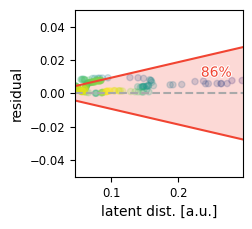

In [10]:
# quantify uncertainty
overconfident_idx = np.argwhere(abs(test_y) > test_uncertainty)

p = 1 - len(overconfident_idx) / len(test_uncertainty)


fig, ax = plot_scatter_residuals_vs_heurestic_uncertainty(test_dist, test_y, qhat, p, xlabel="latent dist. [a.u.]")
fig

The expected confidence level is 90% while we obtain the observed confidence level as 86%. We note that the way training and test data are generated is impractical during regular data generation step. 